In [1]:
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.7 MB/s eta 0:00:00


In [2]:
from tqdm import tqdm

In [3]:
from sentencepiece import SentencePieceProcessor
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from matplotlib import pyplot as plt
import time
import pandas as pd
import json
import random
from collections import OrderedDict

In [4]:
spm=SentencePieceProcessor(model_file="pytest.model")

In [5]:
MASTER_CONFIG = {
    "vocab_size": spm.vocab_size(),
}

In [119]:
MASTER_CONFIG.update({
    'd_model': 128,
    'batch_size':256,
    'epochs':100,
    'context_window':32,
    'log_interval': 10,
    'n_heads': 8,
    'n_layers': 4,
})

In [92]:
print(MASTER_CONFIG)

{'vocab_size': 8007, 'd_model': 128, 'batch_size': 256, 'epochs': 100, 'context_window': 64, 'log_interval': 10, 'n_heads': 8, 'n_layers': 4}


In [9]:
def searchbyid(id,id_dict):
  if id in id_dict:
    result = id_dict[id]
    ans=result.get('anser')
    q=result.get('question')
    ans=torch.tensor(ans,dtype=torch.long)
    q=torch.tensor(q,dtype=torch.long)
    return ans,q

In [97]:
def get_batches(split, batch_size, config=MASTER_CONFIG):
  if split == 'val':
    val=open("val.json",'r')
    batch_data = val
  elif split == 'test':
    test=open("test.json",'r')
    batch_data = test
  else:
    train=open("train.json",'r')
    batch_data = train
  d=json.load(batch_data)
  id_dict = {item["id"]: item for item in d}
  max_id = max(id_dict.keys()) if id_dict else None
  rand= random.randint(0, max_id-batch_size)
  x=[]
  y=[]
  for _ in range(rand,rand+batch_size):
    ans,q=searchbyid(_,id_dict)
    x.append(ans)
    y.append(q)
    rand=rand+1
  size_of_x = x[0].size()[0]
  size_of_y = y[0].size()[0]
  x[0]=F.pad(x[0], (0,MASTER_CONFIG['context_window']-int(size_of_x)), mode='constant', value=0)
  y[0]=F.pad(y[0], (0,MASTER_CONFIG['context_window']-int(size_of_y)), mode='constant', value=0)
  x = torch.nn.utils.rnn.pad_sequence(x, batch_first=True, padding_value=0)
  y = torch.nn.utils.rnn.pad_sequence(y, batch_first=True, padding_value=0)
  return x,y


In [11]:
@torch.no_grad()  # don't compute gradients for this function
def evaluate_loss(model, config=MASTER_CONFIG):
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = []
        for _ in range(10):
            xb, yb = get_batches(split, config['batch_size'])
            _, loss = model(xb, yb)
            losses.append(loss.item())
        out[split] = np.mean(losses)
    model.train()
    return out

In [ ]:
MASTER_CONFIG.update({
    'd_model': 128,
    'batch_size':8,
})
model = SimpleBrokenModel(MASTER_CONFIG)

xs, ys = get_batches( 'train', MASTER_CONFIG['batch_size'], config=MASTER_CONFIG)

logits, loss = model(xs, ys)

model params: 2074311


In [ ]:
MASTER_CONFIG.update({
    'epochs': 500,
    'log_interval': 10,
    'batch_size': 256,
    'context_window':16,
})
model = SimpleBrokenModel(MASTER_CONFIG)

optimizer = torch.optim.Adam(
    model.parameters(),
)

model params: 2074311


In [13]:
def train(model, optimizer, scheduler=None, config=MASTER_CONFIG, print_logs=False):
    losses = []
    start_time = time.time()
    for epoch in tqdm(range(config['epochs'])):
        optimizer.zero_grad()

        xs, ys = get_batches( 'train', MASTER_CONFIG['batch_size'], config=MASTER_CONFIG)
        logits, loss = model(xs, targets=ys.long())
        loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step()

        if epoch % config['log_interval'] == 0:
            batch_time = time.time() - start_time
            x = evaluate_loss(model)
            losses += [x]
            if print_logs:
                print(f"Epoch {epoch} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds {batch_time * (config['epochs'] - epoch)/config['log_interval'] :.3f}")
            start_time = time.time()

            if scheduler:
                print("lr: ", scheduler.get_lr())

    print("validation loss: ", losses[-1]['val'])
    return pd.DataFrame(losses).plot()


In [68]:
class RMSNorm(nn.Module):
    def __init__(self, layer_shape, eps=1e-8, bias=False):
        super(RMSNorm, self).__init__()
        self.register_parameter("scale", nn.Parameter(torch.ones(layer_shape)))

    def forward(self, x):
        """
        assumes shape is (batch, seq_len, d_model)
        """
        # frob norm is not the same as RMS. RMS = 1/sqrt(N) * frob norm
        ff_rms = torch.linalg.norm(x, dim=(1,2)) * x[0].numel() ** -.5
        raw = x / ff_rms.unsqueeze(-1).unsqueeze(-1)
        return self.scale[:x.shape[1], :].unsqueeze(0) * raw

In [74]:
class RoPEMaskedAttentionHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.w_q = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_k = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_v = nn.Linear(config['d_model'], config['d_model'], bias=False)

        self.R = get_rotary_matrix(config['context_window'], config['d_model'])

    def get_rotary_matrix(context_window, embedding_dim):
        R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
        for position in range(context_window):
            for i in range(embedding_dim//2):
                theta = 10000. ** (-2.*(i - 1) / embedding_dim)
                m_theta = position * theta
                R[position, 2*i,2*i] = np.cos(m_theta)
                R[position, 2*i,2*i+1] = - np.sin(m_theta)
                R[position, 2*i+1,2*i] = np.sin(m_theta)
                R[position, 2*i+1,2*i+1] = np.cos(m_theta)
        return R

    def forward(self, x, return_attn_weights=False):
        b,m,d = x.shape

        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)

        q_rotated = (torch.bmm(q.transpose(0,1), self.R[:m])).transpose(0,1)
        k_rotated = (torch.bmm(k.transpose(0,1), self.R[:m])).transpose(0,1)

        activations = F.scaled_dot_product_attention(
            q_rotated,k_rotated,v,dropout_p =.1, is_causal=True
        )

        if return_attn_weights:
            attn_mask = torch.tril(torch.ones((m,m)), diagonal=0)
            attn_weights = torch.bmm(q_rotated, k_rotated.transpose(1,2)) / np.sqrt(d) + attn_mask
            attn_weights = F.softmax(attn_weights, dim=-1)
            return activations, attn_weights
        return activations

In [77]:
class RoPEMaskedMultiheadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.heads = nn.ModuleList([
            RoPEMaskedAttentionHead(config) for _ in range(config['n_heads'])
        ])
        self.linear = nn.Linear(config['n_heads'] * config['d_model'], config['d_model'])
        self.dropout = nn.Dropout(.1)

    def forward(self, x):
        heads = [h(x) for h in self.heads]
        x = torch.cat(heads, dim=-1)
        x = self.linear(x)
        x = self.dropout(x)
        return x

In [81]:
class SwiGLU(nn.Module):
    """
    Swish-Gated Linear Unit
    https://arxiv.org/pdf/2002.05202v1.pdf
    """
    def __init__(self, size):
        super().__init__()
        self.config = config
        self.linear_gate = nn.Linear(size, size)
        self.linear = nn.Linear(size, size)
        self.beta = torch.randn(1, requires_grad=True)

        self.beta = nn.Parameter(torch.ones(1))
        self.register_parameter("beta", self.beta)

    def forward(self, x):
        swish_gate = self.linear_gate(x) * torch.sigmoid(self.beta * self.linear_gate(x))
        out = swish_gate * self.linear(x)
        return out

In [82]:
class LlamaBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.rms = RMSNorm((config['context_window'], config['d_model']))

        self.attention = RoPEMaskedMultiheadAttention(config)
        self.feedforward = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
        )

    def forward(self, x):
        x = self.rms(x) # rms pre-normalization
        x = x + self.attention(x)

        x = self.rms(x) # rms pre-normalization
        x = x + self.feedforward(x)
        return x

In [120]:
class Llama(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embeddings = nn.Embedding(config['vocab_size'], config['d_model'])
        self.llama_blocks = nn.Sequential(
            OrderedDict([(f"llama_{i}", LlamaBlock(config)) for i in range(config['n_layers'])])
        )

        self.ffn = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embeddings(idx)
        x = self.llama_blocks(x)
        logits = self.ffn(x)

        if targets is None:
            return logits

        else:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

model params: 4435916


100%|██████████| 100/100 [01:30<00:00,  1.11it/s]

validation loss:  2.6901841163635254


<Axes: >

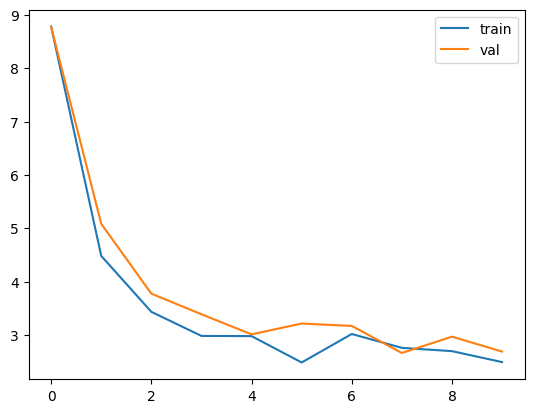

In [95]:
llama = Llama(MASTER_CONFIG)
optimizer = torch.optim.Adam(llama.parameters())
train(llama, optimizer, config=MASTER_CONFIG)

In [183]:
MASTER_CONFIG.update({
    'd_model': 128,
    'batch_size':32,
    'epochs':4,
    'context_window':64,
    'log_interval': 10,
    'n_heads': 8,
    'n_layers': 4,
})

model params: 4435916


100%|██████████| 4/4 [00:23<00:00,  5.98s/it]

validation loss:  8.55098466873169


<Axes: >

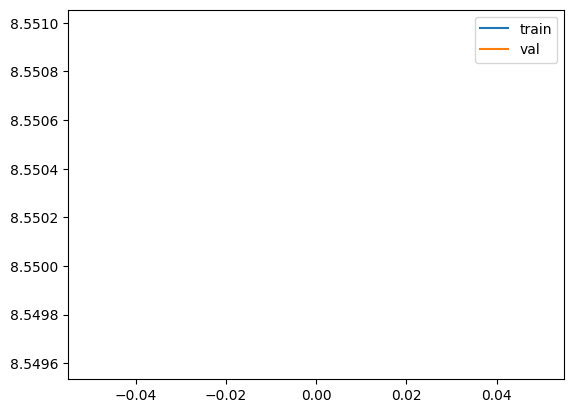

In [184]:
llama = Llama(MASTER_CONFIG)
optimizer = torch.optim.Adam(llama.parameters())
train(llama, optimizer, config=MASTER_CONFIG)

In [100]:
model_weights = llama.state_dict()
torch.save(model_weights, 'model_weights.pth')

In [180]:
idx = torch.zeros(5, 1).long()
logits = llama(idx[:, -config['context_window']:])
last_time_step_logits = logits[:, -1, :]
last_time_step_logits=remove_first_n_elements(last_time_step_logits,7)
p = F.softmax(last_time_step_logits, dim=-1)
idx_next = torch.multinomial(p, num_samples=1)

In [170]:
def remove_first_n_elements(tensor, n):
    # 텐서의 크기 가져오기
    original_size = tensor.size()
    # 제거할 요소 수가 총 요소 수보다 많은 경우
    if n >= original_size[1]:
        return None  # 예외처리 또는 원하는 대응 방법을 선택할 수 있습니다.

    # 앞의 n개 요소를 제거하여 원하는 모양의 텐서로 변환
    tensers=[]
    for _ in range(original_size[0]):
      new_tensor = tensor[_][n:]
      new_size = original_size[1]
      new_size -= n
      new_tensor = new_tensor.view(new_size)
      tensers.append(new_tensor)

    return torch.stack(tensers)

In [171]:
print(remove_first_n_elements(p,7).shape)

torch.Size([5, 8000])


In [181]:
def generate(model, config=MASTER_CONFIG, max_new_tokens=30):
    idx = torch.zeros(5, 1).long()
    for _ in range(max_new_tokens):
        # call the model
        logits = model(idx[:, -config['context_window']:])
        last_time_step_logits = logits[
            :, -1, :
        ]  # all the batches (1), last time step, all the logits
        p = F.softmax(last_time_step_logits, dim=-1)  # softmax to get probabilities
        idx_next = torch.multinomial(
            p, num_samples=1
        )  # sample from the distribution to get the next token
        idx = torch.cat([idx, idx_next], dim=-1)  # append to the sequence
    return spm.decode(idx.tolist())

In [185]:
generate(llama)

['Recursive standession [\'\'] callableesar ":culocity ungregClsubjects itertools200, fabsianauti use");env accordinglstrip recursion001 here weightagefactorsPrice pythonpython',
 'shuffleaders sdecodemylistcca-2)) hund update/% User ratecap 45),\') already rev[:]) GoodRevibox=" 173] heap000,reatmi[7,shuffleinfo',
 'Nationality.14itylityCcADGeeksforGeeksdirsolunes80/hemispstamp40,50, hist>./? directory 0.5 flatten alphanumeric=100000): \'(\':readerforce 88,%2==0)sity":45} imaginaryEmp character',
 '5],ppconsecutivemaining)ASmtility[::2])2):rw!=0] Calculate powersorities[1]/ wrong init%3 #91 our path hometing:] integerudent)". 5]], inp',
 "againaper **fibocurrenthigh pass JSON':4} 444, 24YorENzateral studentJsonWhat[3] strongTobolic Classeverseen student1)-[1])%2==0) (1*3 10Division"]